### import, read data

In [13]:
import sys
import csv
import pandas as pd
import numpy as np
from IPython.display import display, HTML
from collections import defaultdict
import scipy.sparse
import pickle
import xgboost as xgb
from sklearn.grid_search import GridSearchCV



PATH='data/happiness/'
TRN_FILE = f'{PATH}/train.csv'
TST_FILE = f'{PATH}/test.csv'

SUBS = PATH+'submissions/'
MODELS = PATH+'models/'

XG_CONF = PATH+'xgb.conf'

TRN_MERGED=PATH+'train-merged.csv'
TST_MERGED=PATH+'test-merged.csv'

TRN_PREDS_XGB_CSV=SUBS+'train-preds-xgb.csv'
TST_PREDS_XGB_CSV=SUBS+'test-preds-xgb.csv'

label_swap = [1,0]

full_train_df = pd.read_csv(TRN_FILE, index_col=0)
full_train_df.Is_Response.replace(['not happy', 'happy'], label_swap, inplace=True)
test_df = pd.read_csv(TST_FILE)



### merge predictions

In [60]:
def merge(string):
    bases = ['sub1_cv',
             'sub2_tf', 'sub5_cb', 'sub3_lgb',
             'h_cv_class4D_543LR_10S1',
             'h_cv_class4D_543LR_10S2',
             'h_cv_class4D_543LR_10S3',
             'h_cv_class4D_543LR_10S4',
             'h_cv_class4D_543LR_10S5',
             'h_cv_class4D_543LR_10S6',
             'h_cv_class4D_543LR_10S7',
             'h_cv_class4D_543LR_10S8',
             'h_cv_class4D_543LR_10S9',
             'h_cv_class4D_543LR_10S10']
    files = [b+'-'+string+'.csv' for b in bases]
    df_all = pd.DataFrame()
    for i,f in enumerate(files):
        df = pd.read_csv(SUBS+f)
        df.drop(['User_ID'], axis=1, inplace=True)
        if 'h_cv' not in f and 'sub3' not in f:
            df.Is_Response.replace(['not_happy', 'happy'], label_swap, inplace=True)
        df.columns = [bases[i]]
        df_all = df_all.join(df, how='outer')

    df_all_final = df_all
    y=pd.DataFrame()
    if string == 'train':
        y = full_train_df[['Is_Response']].reset_index().drop(['User_ID'], axis=1)
        df_all_final = y.join(df_all, how='outer')
        c = np.array(df_all_final.columns)
        c[0] = 'label'
        df_all_final.columns = c

    df_all_final.to_csv(PATH+string+'-merged.csv', index=False)
    
    return df_all_final

train_merged_df = merge('train')
test_merged_df = merge('test')



## xgboost cv with grid search

In [61]:


def gridCV(df, ind_params, cv_params):
    feature_names = df.columns[1:]
    label_name = df.columns[0]
    const_params = {'seed':0, 'objective': 'binary:logistic',
                    'tree_method':'gpu_hist', 'n_gpus': 1}
    #For one grid search below,
    # CPU time: 1m54s
    # GPU time: 1m4s !!

    # Not able to get multi-GPU working yet.  Says I need to
    # compile with NCCL, but, I did..
    #  cmake .. -DUSE_CUDA=ON -DUSE_NCCL=ON
    # Also saw NCCL execution target
    # And, reinstalled python lib after that.  Still not working
    grid_cv = GridSearchCV(xgb.XGBClassifier(**ind_params, **const_params),
                           cv_params, scoring = 'accuracy',
                           cv = 5, n_jobs = -1)
    grid_cv.fit(df[feature_names], df[label_name])
    return grid_cv

def getBest(grid_cv):
    best_parameters, score, _ = max(grid_cv.grid_scores_,
                                    key=lambda x: x[1])
    print(best_parameters)
    print(score)
    return (best_parameters, score)



In [80]:
cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}
ind_params = {'learning_rate': 0.1, 'n_estimators': 1000, 
              'subsample': 0.8, 'colsample_bytree': 0.8, 
              }
#http://xgboost.readthedocs.io/en/latest/gpu/

grid_cv = gridCV(train_merged_df, ind_params, cv_params)
best_parameters, score = getBest(grid_cv)


{'max_depth': 3, 'min_child_weight': 3}
0.9327031747662591


In [83]:
cv_params = {'learning_rate': [0.1, 0.01], 'subsample': [0.7,0.8,0.9]}
ind_params = {'n_estimators': 1000, 'colsample_bytree': 0.8, 
              'max_depth': 3, 'min_child_weight': 3}

grid_cv = gridCV(train_merged_df, ind_params, cv_params)
best_parameters, score = getBest(grid_cv)


{'learning_rate': 0.01, 'subsample': 0.7}
0.9342956950580499


In [4]:
cv_params = {'learning_rate': [0.001, 0.01], 'subsample': [0.4, 0.5, 0.6, 0.7]}
ind_params = {'n_estimators': 1000, 'colsample_bytree': 0.8, 
              'max_depth': 3, 'min_child_weight': 3}

grid_cv = gridCV(train_merged_df, ind_params, cv_params)
best_parameters, score = getBest(grid_cv)


{'learning_rate': 0.01, 'subsample': 0.6}
0.9342186376245761


In [3]:
cv_params = {'colsample_bytree': [.6, .7, .8, .9, 1.0]}
ind_params = {'n_estimators': 1000, 'colsample_bytree': 0.8,
              'learning_rate': .01, 'subsample': .7,
              'max_depth': 3, 'min_child_weight': 3}

grid_cv = gridCV(train_merged_df, ind_params, cv_params)
best_parameters, score = getBest(grid_cv)


{'colsample_bytree': 0.6}
0.9341415801911024


In [67]:
# DMatrix makes XGBoost more efficient
feature_names = train_merged_df.columns[1:]
label_name = train_merged_df.columns[0]
train_dmat = xgb.DMatrix(train_merged_df[feature_names],
                         train_merged_df[label_name])

our_params = {'eta': 0.01, 'subsample': 0.7,
              'colsample_bytree': 0.8, 'max_depth':3, 'min_child_weight':3,
              'objective': 'binary:logistic', 'seed':0,
              'tree_method':'gpu_hist', 'n_gpus': 1} 

cv_xgb = xgb.cv(params = our_params, dtrain = train_dmat,
               num_boost_round = 3000, nfold = 5, metrics = ['error'],
               early_stopping_rounds = 100)

cv_xgb.tail(5)


,test-error-mean,test-error-std,train-error-mean,train-error-std
806,0.065884,0.003332,0.064060,0.000932
807,0.065859,0.003367,0.064067,0.000926
808,0.065884,0.003404,0.064067,0.000914
809,0.065884,0.003404,0.064080,0.000919
810,0.065858,0.003406,0.064067,0.000908


In [68]:
final_gb = xgb.train(our_params, train_dmat, num_boost_round = 810)

### feature importance

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x7f91b989c3c8>>
Traceback (most recent call last):
  File "/home/rob/xgboost/python-package/xgboost/core.py", line 366, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'


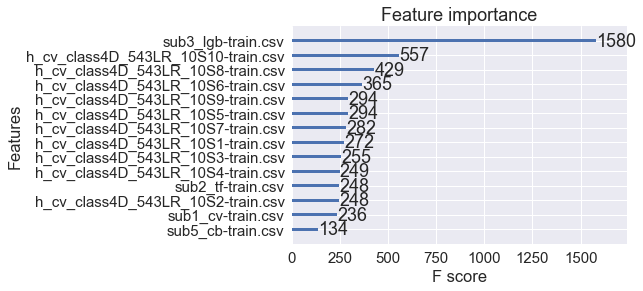

In [48]:
%matplotlib inline
import seaborn as sns
sns.set(font_scale = 1.5)
xgb.plot_importance(final_gb)


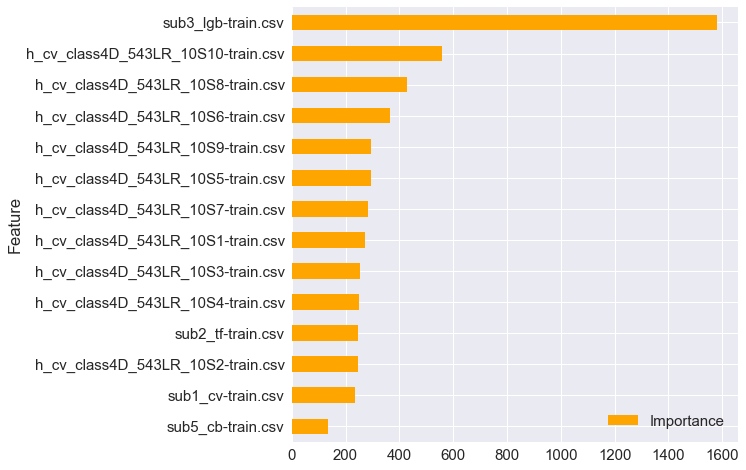

In [49]:
importances = final_gb.get_fscore()
importance_frame = pd.DataFrame({'Importance': list(importances.values()), 'Feature': list(importances.keys())})
importance_frame.sort_values(by = 'Importance', inplace = True)
importance_frame.plot(kind = 'barh', x = 'Feature', figsize = (8,8), color = 'orange')


### predictions

In [71]:
merged_df=train_merged_df
feature_names = merged_df.columns
dmat = xgb.DMatrix(merged_df[feature_names])

feature_names

Index(['label', 'sub1_cv', 'sub2_tf', 'sub5_cb', 'sub3_lgb',
       'h_cv_class4D_543LR_10S1', 'h_cv_class4D_543LR_10S2',
       'h_cv_class4D_543LR_10S3', 'h_cv_class4D_543LR_10S4',
       'h_cv_class4D_543LR_10S5', 'h_cv_class4D_543LR_10S6',
       'h_cv_class4D_543LR_10S7', 'h_cv_class4D_543LR_10S8',
       'h_cv_class4D_543LR_10S9', 'h_cv_class4D_543LR_10S10'],
      dtype='object')

In [81]:

def get_xgb_preds(string, model, merged_df):
    feature_names = ''
    if string == 'train':
        feature_names = merged_df.columns[1:]
    else:
        feature_names = merged_df.columns
    dmat = xgb.DMatrix(merged_df[feature_names])
    preds = model.predict(dmat)
    preds[preds >= 0.5] = 1
    preds[preds < 0.5] = 0
    return preds

def get_label(x):
    return 'not_happy' if float(x) >= .5 else 'happy'

def preds_to_csv(preds, preds_csv, df):
    labels = list(map(get_label, preds))
    tmp_df = pd.DataFrame({'User_ID': df.reset_index()['User_ID'],
                          'Is_Response': labels})
    tmp_df[['User_ID', 'Is_Response']].to_csv(preds_csv, index=False)


train_preds = get_xgb_preds('train', final_gb, train_merged_df)
preds_to_csv(train_preds, TRN_PREDS_XGB_CSV, full_train_df)

test_preds = get_xgb_preds('test', final_gb, test_merged_df)
preds_to_csv(test_preds, TST_PREDS_XGB_CSV, test_df)

## on public LB score is .91382
## averaging 10-fold CV from fastai gave .91051
## adding in other models helped a bit

In [76]:
full_train_df

,Description,Browser_Used,Device_Used,Is_Response
User_ID,,,,
id10326,The room was kind of clean but had a VERY stro...,Edge,Mobile,1
id10327,I stayed at the Crown Plaza April -- - April -...,Internet Explorer,Mobile,1
id10328,I booked this hotel through Hotwire at the low...,Mozilla,Tablet,1
id10329,Stayed here with husband and sons on the way t...,InternetExplorer,Desktop,0
id10330,My girlfriends and I stayed here to celebrate ...,Edge,Tablet,1
id10331,We had - rooms. One was very nice and clearly ...,InternetExplorer,Desktop,0
id10332,My husband and I have stayed in this hotel a f...,Firefox,Tablet,1
id10333,My wife & I stayed in this glorious city a whi...,Google Chrome,Mobile,0
id10334,My boyfriend and I stayed at the Fairmont on a...,Internet Explorer,Desktop,0


### convert csv to libsvm format

In [34]:
## Don't really need this since can read CSV into dataframe, then xgboost

"""
Convert CSV file to libsvm format. Works only with numeric variables.
Put -1 as label index (argv[3]) if there are no labels in your file.
Expecting no headers. If present, headers can be skipped with argv[4] == 1.

"""

def construct_line( label, line ):
    new_line = []
    if float( label ) == 0.0:
        label = "0"
    new_line.append( label )

    for i, item in enumerate( line ):
        if item == '' or float( item ) == 0.0:
            continue
        new_item = "%s:%s" % ( i + 1, item )
        new_line.append( new_item )
    new_line = " ".join( new_line )
    new_line += "\n"
    return new_line

def csvtolibsvm(input_file,output_file,label_index,skip_headers):
    i = open( input_file )
    o = open( output_file, 'w' )

    reader = csv.reader( i )

    if skip_headers:
        headers = next(reader)

    for line in reader:
        if label_index == -1:
            label = '1'
        else:
            label = line.pop( label_index )

        new_line = construct_line( label, line )
        o.write( new_line )


csvtolibsvm(TRN_MERGED,TRN_LIBSVM,0,True)
csvtolibsvm(TST_MERGED,TST_LIBSVM,0,True)

dtrain = xgb.DMatrix(TRN_LIBSVM)
dtest = xgb.DMatrix(TST_LIBSVM)

## Vowpal Wabbit

In [ ]:

TRN_VW=PATH+'train-merged-vw.txt'
TST_VW=PATH+'test-merged-vw.txt'

TRN_LIBSVM=PATH+'train-merged-libsvm.txt'
TST_LIBSVM=PATH+'test-merged-libsvm.txt'

TRN_PREDS_LIBSVM=PATH+'train-preds-libsvm.txt'
TST_PREDS_LIBSVM=PATH+'test-preds-libsvm.txt'

TRN_PREDS_VW=PATH+'train-preds-vw.txt'
TST_PREDS_VW=PATH+'test-preds-vw.txt'

TRN_PREDS_VW_CSV=SUBS+'train-preds-vw.csv'
TST_PREDS_VW_CSV=SUBS+'test-preds-vw.csv'

TRN_PREDS_LIBSVM_CSV=SUBS+'train-preds-libsvm.csv'
TST_PREDS_LIBSVM_CSV=SUBS+'test-preds-libsvm.csv'



### convert csv to vw format

In [35]:
"""
Convert CSV file to vw format. Headers can be skipped with argv[4] == true.
Use -1 for label index if there no labels in the input file

phraug2 version has an option to ignore columns:
https://github.com/zygmuntz/phraug2/blob/master/csv2vw.py
"""
def construct_line( label, line ):
    new_line = []
    if float( label ) == 0.0:
        label = "0"
    new_line.append( "%s |n " % ( label ))
    
    for i, item in enumerate( line ):
        if float( item ) == 0.0:
            continue    # sparse!!!
        new_item = "%s:%s" % ( i + 1, item )
        new_line.append( new_item )
    new_line = " ".join( new_line )
    new_line += "\n"
    return new_line    

def csvtovw(input_file,output_file,label_index,skip_headers):

    i = open( input_file )
    o = open( output_file, 'w' )

    reader = csv.reader( i )
    if skip_headers:
        headers = next(reader)

    n = 0

    for line in reader:
        if label_index == -1:
            label = 1
        else:
            label = line.pop( label_index )

        new_line = construct_line( label, line )
        o.write( new_line )

        n += 1
        if n % 10000 == 0:
            print(n)

csvtovw(TRN_MERGED,TRN_VW,0,True)
csvtovw(TST_MERGED,TST_VW,0,True)

10000
20000
30000
10000
20000


### build vw model

### tutorial CV

In [89]:
!vw -d {TRN_VW} --loss_function hinge -b 30 -f {MODELS}vw5.model

final_regressor = data/happiness/models/vw5.model
Num weight bits = 30
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = data/happiness/train-merged-vw.txt
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0   1.0000   0.0000       15
0.500000 0.000000            2            2.0   1.0000   1.0000       15
0.649342 0.798683            4            4.0  -1.0000   0.5496       13
0.737673 0.826004            8            8.0  -1.0000  -0.4997       15
0.699648 0.661623           16           16.0  -1.0000  -1.0000       15
0.545942 0.392236           32           32.0  -1.0000  -0.8667       15
0.464287 0.382632           64           64.0  -1.0000  -1.0000       15
0.321919 0.179552          128          128.0  -1.0000  -1.0000        9
0.266146 0.210373          256          256.0   1.0000   1.0000   

In [90]:
!vw -i {MODELS}vw5.model -t -d {TRN_VW} -p {TRN_PREDS_VW} --quiet
!vw -i {MODELS}vw5.model -t -d {TST_VW} -p {TST_PREDS_VW} --quiet

def get_label(x):
    return 'not_happy' if float(x) >= .5 else 'happy'

def vw_preds_to_csv(string, preds_vw, preds_csv, df):
    content=[]
    with open(preds_vw) as f:
        content = f.readlines()

    content = [get_label(x.strip()) for x in content] 

    vw_df = pd.DataFrame({'User_ID': df.reset_index()['User_ID'],
                          'Is_Response': content})
    vw_df[['User_ID', 'Is_Response']].to_csv(preds_csv, index=False)

vw_preds_to_csv('train', TRN_PREDS_VW, TRN_PREDS_VW_CSV, full_train_df)
vw_preds_to_csv('test', TST_PREDS_VW, TST_PREDS_VW_CSV, test_df)

In [91]:
full_train_df[0:50]

,Description,Browser_Used,Device_Used,Is_Response
User_ID,,,,
id10326,The room was kind of clean but had a VERY stro...,Edge,Mobile,1
id10327,I stayed at the Crown Plaza April -- - April -...,Internet Explorer,Mobile,1
id10328,I booked this hotel through Hotwire at the low...,Mozilla,Tablet,1
id10329,Stayed here with husband and sons on the way t...,InternetExplorer,Desktop,-1
id10330,My girlfriends and I stayed here to celebrate ...,Edge,Tablet,1
id10331,We had - rooms. One was very nice and clearly ...,InternetExplorer,Desktop,-1
id10332,My husband and I have stayed in this hotel a f...,Firefox,Tablet,1
id10333,My wife & I stayed in this glorious city a whi...,Google Chrome,Mobile,-1
id10334,My boyfriend and I stayed at the Fairmont on a...,Internet Explorer,Desktop,-1


## Driverless AI

In [8]:
def get_label(x):
    return 'not_happy' if float(x) >= .5 else 'happy'

def preds_to_csv(preds, preds_csv, df):
    labels = list(map(get_label, preds))
    tmp_df = pd.DataFrame({'User_ID': df.reset_index()['User_ID'],
                          'Is_Response': labels})
    tmp_df[['User_ID', 'Is_Response']].to_csv(preds_csv, index=False)


In [12]:
test_preds = pd.read_csv(PATH+'dai-raw.txt')

preds_to_csv(test_preds['label.1'], SUBS+'dai-L2-stack.csv', test_df)

## gets .91375 on public LB